In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
def classification_metrics(Y_true, Y_pred):
    ## Shape of Classification Matrix
    ## TP  FN
    ## FP  TN
    n = np.shape(Y_true)[0]
    class metric:
        matrix = np.empty((2,2))
        recall = float()
        specificity = float()
        fallout = float()
        ppv = float()
        accuracy = float()
        missclassification = float()
    metrics = metric()
    tp = tn = fp = fn = 0
    for i in range(n):
        if Y_true[i] == Y_pred[i]:
            if Y_true[i] == 1:
                tp += 1
            if Y_true[i] == 0:
                tn += 1
        if Y_true[i] != Y_pred[i]:
            if Y_true[i] == 1:
                fn += 1
            if Y_true[i] == 0:
                fp += 1
    confusion = np.array([[tp, fn], [fp, tn]])
    metrics.matrix = confusion
    metrics.recall = confusion[0,0]/(confusion[0,0]+confusion[0,1])
    metrics.specificity = confusion[1,1]/(confusion[1,1]+confusion[1,0])
    metrics.fallout = confusion[1,0]/(confusion[1,0]+confusion[1,1])
    metrics.ppv = confusion[0,0]/(confusion[0,0]+confusion[1,0])
    metrics.accuracy = (confusion[0,0]+confusion[1,1])/np.sum(confusion)
    metrics.missclassification = (confusion[0,1]+confusion[1,0])/np.sum(confusion)
    
    return metrics

def print_metrics(metrics):
    print('The confusion matrix is        ', metrics.matrix[0,:])
    print('                               ', metrics.matrix[1,:])
    print('\n')
    print('The metrics are:        Fallout =', round(metrics.fallout,4),
          '               Recall =', round(metrics.recall,4))
    print('                    Specificity =', round(metrics.specificity,4),
          '                  PPV =', round(metrics.ppv,4))
    print('                       Accuracy =', round(metrics.accuracy,4),
          ' Missclass Error Rate =', round(metrics.missclassification,4))

In [4]:
conductivity = pd.read_csv("data/train.csv", header=0, na_values='?').dropna()
conductivity.head()
print('\nDataFrame datatypes :\n', conductivity.dtypes)


DataFrame datatypes :
 number_of_elements         int64
mean_atomic_mass         float64
wtd_mean_atomic_mass     float64
gmean_atomic_mass        float64
wtd_gmean_atomic_mass    float64
                          ...   
range_Valence              int64
wtd_range_Valence        float64
std_Valence              float64
wtd_std_Valence          float64
critical_temp            float64
Length: 82, dtype: object


In [5]:
X = conductivity.drop(['critical_temp'], axis=1) 
X = X.values 
Y = conductivity.iloc[:,81:82].values

import sklearn.model_selection as cv 
XTrain, XTest, YTrain, Ytest = cv.train_test_split(X, Y, test_size=0.2, random_state=42)

We are going to tune the max number of leaves and the max depth for a regression tree.

In [7]:
depth = np.arange(2,11)
leaves = np.arange(1,31,step=9)

from sklearn import tree

grid_decision = grid_bagged = [{'max_depth': depth, 'min_samples_leaf': leaves}]

decision_model = tree.DecisionTreeRegressor(criterion='mse')
bagged_model = RandomForestRegressor(max_features=81, random_state=42)

from sklearn.model_selection import GridSearchCV

cv_decision = GridSearchCV(estimator = decision_model, 
                           param_grid=grid_decision,
                           cv=ms.KFold(n_splits=10))

cv_decision.fit(XTrain, YTrain)

best_decision_depth = cv_decision.best_params_['max_depth']
best_decision_samples = cv_decision.best_params_['min_samples_leaf']

10

First we fit our regression tree, after which we consider some ensemble methods.

In [8]:
decision_model = tree.DecisionTreeRegressor(criterion='mse',
                                            max_depth=10,
                                            min_samples_leaf=10)
decision_model.fit(XTrain,YTrain)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)

In [9]:
decision_train_pred = decision_model.predict(XTrain)
decision_test_pred = decision_model.predict(XTest)
decision_train_mse = mean_squared_error(YTrain, decision_train_pred)
decision_test_mse = mean_squared_error(Ytest, decision_test_pred)

150.068932524657

The five most important variables are ['range_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'std_Density', 'wtd_gmean_Valence', 'wtd_range_Valence'] with importances [0.5896, 0.1352, 0.0296, 0.0194, 0.0189] respectively
Decision tree training MSE is: 118.1069  and the testing MSE is: 150.0689


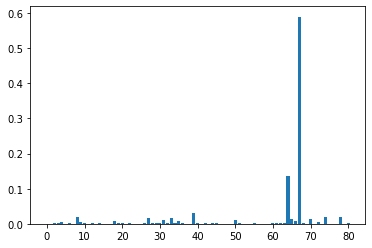

In [10]:
decision_model.feature_importances_
plt.bar(x=range(81),height=decision_model.feature_importances_)
importance_dec = pd.DataFrame(decision_model.feature_importances_,columns=['Importance'])
importance_dec.insert(0, 'Variable', range(0,81))
importance_dec = importance_dec.sort_values(by=['Importance'], ascending=False)
names1 = conductivity.columns[importance_dec.iloc[0:5,0]]
high1 = round(importance_dec.iloc[0:5,1],4)
print('The five most important variables are', list(names1), 'with importances', list(high1), 'respectively')

print('Decision tree training MSE is:', round(decision_train_mse,4),
      ' and the testing MSE is:', round(decision_test_mse, 4))

The ensemble methods under consideration are bagging, random forest and boosted regression trees.

In [11]:
bagged_model = RandomForestRegressor(max_features=81, random_state=42)
bagged_model.fit(XTrain,np.ravel(YTrain))

rforest_model = RandomForestRegressor(max_features=9, random_state=42)
rforest_model.fit(XTrain, np.ravel(YTrain))

boosted_model = GradientBoostingRegressor(n_estimators=500,
                                          learning_rate=0.2,
                                          max_depth=4,
                                          random_state=42)
boosted_model.fit(XTrain, np.ravel(YTrain))

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=500,
                          random_state=42)

The five most important variables are ['range_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'std_atomic_mass', 'wtd_gmean_Valence', 'wtd_entropy_ThermalConductivity'] with importances [0.5364, 0.1262, 0.0231, 0.0191, 0.0122] respectively
Bagged tree training MSE is: 26.2656  and the testing MSE is: 81.4034


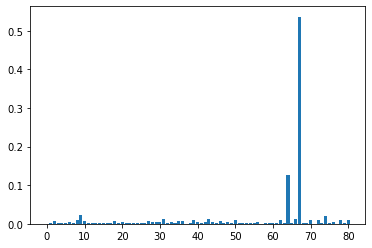

In [12]:
bagged_train_pred = bagged_model.predict(XTrain)
bagged_test_pred = bagged_model.predict(XTest)
bagged_train_mse = mean_squared_error(YTrain, bagged_train_pred) ## = 26.2656
bagged_test_mse = mean_squared_error(Ytest, bagged_test_pred) ## = 81.4034

plt.bar(x=range(81),height=bagged_model.feature_importances_)
importance_bagged = pd.DataFrame(bagged_model.feature_importances_,columns=['Importance'])
importance_bagged.insert(0, 'Variable', range(0,81))
importance_bagged = importance_bagged.sort_values(by=['Importance'], ascending=False)
names2 = conductivity.columns[importance_bagged.iloc[0:5,0]]
high2 = round(importance_bagged.iloc[0:5,1],4)
print('The five most important variables are', list(names2), 'with importances', list(high2), 'respectively')

print('Bagged tree training MSE is:', round(bagged_train_mse,4),
      ' and the testing MSE is:', round(bagged_test_mse, 4))

The five most important variables are ['range_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_mean_Valence', 'wtd_entropy_Valence', 'wtd_entropy_atomic_mass'] with importances [0.1, 0.0867, 0.0801, 0.0545, 0.0539] respectively
Random Forest tree training MSE is: 25.8544  and the testing MSE is: 80.5137


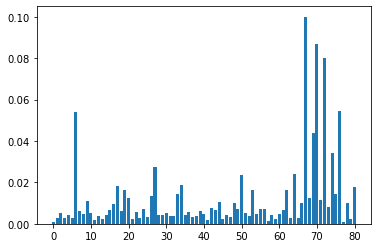

In [13]:
rforest_train_pred = rforest_model.predict(XTrain)
rforest_test_pred = rforest_model.predict(XTest)
rforest_train_mse = mean_squared_error(YTrain, rforest_train_pred)
rforest_test_mse = mean_squared_error(Ytest, rforest_test_pred)

plt.bar(x=range(81),height=rforest_model.feature_importances_)
importance_rforest = pd.DataFrame(rforest_model.feature_importances_,columns=['Importance'])
importance_rforest.insert(0, 'Variable', range(0,81))
importance_rforest = importance_rforest.sort_values(by=['Importance'], ascending=False)
names3 = conductivity.columns[importance_rforest.iloc[0:5,0]]
high3 = round(importance_rforest.iloc[0:5,1],4)
print('The five most important variables are', list(names3), 'with importances', list(high3), 'respectively')

print('Random Forest tree training MSE is:', round(rforest_train_mse,4),
      ' and the testing MSE is:', round(rforest_test_mse, 4))

The five most important variables are ['range_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'range_atomic_radius', 'wtd_mean_ThermalConductivity', 'wtd_gmean_Valence'] with importances [0.4568, 0.0938, 0.0841, 0.0286, 0.0262] respectively
Boosted tree training MSE is: 35.1898  and the testing MSE is: 89.3064


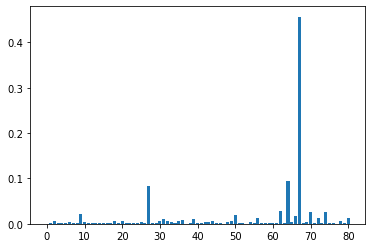

In [14]:
boosted_train_pred = boosted_model.predict(XTrain)
boosted_test_pred = boosted_model.predict(XTest)
boosted_train_mse = mean_squared_error(YTrain, boosted_train_pred)
boosted_test_mse = mean_squared_error(Ytest, boosted_test_pred)

plt.bar(x=range(81),height=boosted_model.feature_importances_)
importance_boosted = pd.DataFrame(boosted_model.feature_importances_,columns=['Importance'])
importance_boosted.insert(0, 'Variable', range(0,81))
importance_boosted = importance_boosted.sort_values(by=['Importance'], ascending=False)
names4 = conductivity.columns[importance_boosted.iloc[0:5,0]]
high4 = round(importance_boosted.iloc[0:5,1],4)
print('The five most important variables are', list(names4), 'with importances', list(high4), 'respectively')

print('Boosted tree training MSE is:', round(boosted_train_mse,4),
      ' and the testing MSE is:', round(boosted_test_mse, 4))

In [15]:
linear_model = LinearRegression()
linear_model.fit(XTrain, YTrain)

linear_train_pred = linear_model.predict(XTrain)
linear_test_pred = linear_model.predict(XTest)
linear_train_mse = mean_squared_error(YTrain, linear_train_pred)
linear_test_mse = mean_squared_error(Ytest, linear_test_pred)
print('Linear Regression training MSE is:', round(linear_train_mse,4),
      ' and the testing MSE is:', round(linear_test_mse, 4))

Linear Regression training MSE is: 310.218  and the testing MSE is: 302.0075
